### **Notebook to make predictions with reprocessed Henson data and EFLUX2 and SPOT** 

##### **Import python packages**

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
#import cplex
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
from matplotlib.cbook import get_sample_data
import matplotlib.image as mpimg

from edd_utils import login, export_study, export_metadata

##### **Load data**

In [5]:
# Study to Download
study_slug = 'biodesign_henson2018_reprocessed'
# EDD server
edd_server = 'public-edd.jbei.org'
user       = 'garrettroell'

In [6]:
session = login(edd_server=edd_server, user=user)

df = export_study(session, study_slug, edd_server=edd_server)
#df.head()

Password for garrettroell:  ················


##### **Filter transcriptomics data from all EDD data into different dataframes**

In [8]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,20.0
1,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,32.0
2,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,20.0
3,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,32.0
4,14409,Biodesign_Henson2018_reprocessed,14907,WT-M-R3,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14950,WT-M-R3,NaN,WP_000104864_1,0,FPKM,0.0,20.0


##### **Load Genome Scale Model**

In [9]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import EFLUX2 and SPOT Code**

In [10]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from ensemblemethods import EFlux2,SPOT

##### **Transform data to dataframe with just index as gene identifiers and one column for values**
##### !!!!TODO: Generalize for multiple time points


In [11]:
#Function to construct df from EFLUX2 and SPOT functions: Needs to be modified for multiple time points!!!!!
def constructTransdffrompred(transdata, linename, conditionstring):
    transdataPhe = transdata[transdata['Line Description'].str.contains(conditionstring)]
    transdataWTPR1 = transdataPhe[transdataPhe['Line Name']==linename]
    transdataWTPR1new = transdataWTPR1.filter(['Value', 'Measurement Type'])#pd.DataFrame(data=df_TransWTPR1.loc[:,'Value'], index=df_TransWTPR1['Measurement Type'])
    transdataWTPR1new2 = transdataWTPR1new.set_index('Measurement Type')
    return transdataWTPR1new2

#### **EFLUX2 Predictions**

In [12]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2pred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        try:
            if substrate=='phenol':
                model.objective = 'Growth_Phenol'
                model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
                model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
                medium = {key:1000 for (key,value) in model.medium.items()}
                medium["EX_glc__D_e"] = 0.0
                #medium["EX_phenol_e"] = sub_uptake_rate
            elif substrate=='glucose':
                model.objective = 'Growth_Glucose'
                model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
                model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
                medium = {key:1000 for (key,value) in model.medium.items()}
                #medium["EX_glc__D_e"] = sub_uptake_rate
                medium["EX_phenol_e"] = 0.0
            else:
                print('Unknown substrate: Please choose among phenol and glucose')
            model.medium = medium
            eflux2sol = EFlux2(model, transcriptdf)
        except OptimizationError:
                if substrate=='phenol':
                    model.objective = 'Growth_Phenol'
                    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
                    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
                    medium = {key:10 for (key,value) in model.medium.items()}
                    medium["EX_glc__D_e"] = 0.0
                    #medium["EX_phenol_e"] = sub_uptake_rate
                elif substrate=='glucose':
                    model.objective = 'Growth_Glucose'
                    model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
                    model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
                    medium = {key:10 for (key,value) in model.medium.items()}
                    #medium["EX_glc__D_e"] = sub_uptake_rate
                    medium["EX_phenol_e"] = 0.0
                else:
                    print('Unknown substrate: Please choose among phenol and glucose')
                model.medium = medium
                eflux2sol = EFlux2(model, transcriptdf)
        display(model.medium)
        #spotsol = SPOT(model, constructTransdffrompred(transcriptdf, linename, conditionstring))
    return eflux2sol#, spotsol

In [13]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2predthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    eflux2sol_R1 = eflux2pred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R2 = eflux2pred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R3 = eflux2pred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)

    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std

##### **Wild Type**

In [14]:
eflux2sol, eflux2sol_std = eflux2predthreereps(model, df_Trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

FBA status optimal
FBA solution 0.43724976553939066


EFlux2 status optimal
EFlux2 solution 6142.9548206436375


{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

FBA status optimal
FBA solution 0.3594248668216757


EFlux2 status infeasible
EFlux2 solution 3834.1398580693167


cobra/util/solver.py:416 UserWarning: solver status is 'infeasible'


{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

FBA status optimal
FBA solution 0.41007181188827113


EFlux2 status optimal
EFlux2 solution 10161.095956690522


{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

##### **Save solution to data frame**

In [15]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['stds'])

In [17]:
# eflux2soldf

##### **Check External Metabolites solution**

In [18]:
exchange_list = []
for ind in eflux2soldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)
#exchange_list

In [19]:
eflux2soldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(eflux2soldf.loc[i,:].values)>=0.0001:
        display(eflux2soldf.loc[i,:])
#display(eflux2soldf.loc['EX_phenol_e',:])
    

fluxes    15.261482
Name: EX_h2o_e, dtype: float64

fluxes    1.864641
Name: EX_h_e, dtype: float64

fluxes   -0.002033
Name: EX_cl_e, dtype: float64

fluxes   -0.845827
Name: EX_pi_e, dtype: float64

fluxes   -2.625001
Name: EX_nh4_e, dtype: float64

fluxes   -0.003049
Name: EX_fe3_e, dtype: float64

fluxes   -0.076227
Name: EX_k_e, dtype: float64

fluxes   -0.002033
Name: EX_ca2_e, dtype: float64

fluxes   -0.003388
Name: EX_mg2_e, dtype: float64

fluxes   -0.00027
Name: EX_mn2_e, dtype: float64

fluxes   -0.000133
Name: EX_zn2_e, dtype: float64

fluxes    25.003678
Name: EX_co2_e, dtype: float64

fluxes   -0.000277
Name: EX_cu2_e, dtype: float64

fluxes   -31.303435
Name: EX_o2_e, dtype: float64

fluxes   -0.002622
Name: EX_fe2_e, dtype: float64

fluxes   -0.022649
Name: EX_so4_e, dtype: float64

fluxes   -6.246863
Name: EX_phenol_e, dtype: float64

##### **PVHG6**

In [20]:
# eflux2sol2, eflux2sol_std2 = eflux2predthreereps(model, df_Trans, 'PVHG-P-R1', 'PVHG-P-R2','PVHG-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

##### **Save solution to data frame**

In [21]:
# eflux2soldf2 = pd.DataFrame(eflux2sol2, columns=['fluxes'])
# eflux2solstddf2 = pd.DataFrame(eflux2sol_std2, columns=['stds'])

In [22]:
# eflux2soldf

##### **Check FBA solution**

In [23]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    medium["EX_glc__D_e"] = 0.0
    #medium["EX_phenol_e"] = sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.23577895481228953


##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [33]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')

# Remove rows that do not have a mapping to the GSM
phenol_fluxes.dropna(subset = ["Forward Reactions"], inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 43 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000


#### **Plot solutions: Comparison of EFLUX2 predictions and 13c measurements**

##### **Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [34]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]
def get_std_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.stds[reaction_id]
    else:
        return solution.stds[reaction_id]

##### **Scale up solution to compare with 13C MFA measurements**

In [35]:
def scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method):
    scalepred_stds = pd.DataFrame(index=stdpredictions.index, columns= ['stds'])
    if substrate == 'phenol':
        phenoluptakerow = observed_fluxes[observed_fluxes['Pathway']=='Phenol Uptake']
        sourceuptake = float(phenoluptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_phenol_e']))
    elif substrate == 'glucose':
        glucoseuptakerow = observed_fluxes[observed_fluxes['Pathway']=='Glucose Uptake']
        sourceuptake = float(glucoseuptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
    else:
        print('Unknown Substrate')
    for ind in stdpredictions.index:
        if abs(stdpredictions.loc[ind,'stds'])<1e-5:
            scalepred_stds.loc[ind,'stds'] = stdpredictions.loc[ind,'stds']
        else:
            scalepred_stds.loc[ind,'stds'] = (stdpredictions.loc[ind,'stds']/predictions.loc[ind,'fluxes'])*scalepred_fluxes.loc[ind, 'fluxes']
    return scalepred_fluxes, scalepred_stds

##### **Add predictions to 13c data frame**

In [36]:
def addpredfluxes_to13cdf(observed_fluxes, predictions, stdpredictions, substrate, method):
    predicted_fluxes = []
    predicted_stds = []
    scalepred_fluxes, scalepred_stds = scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method)
    for _, row in observed_fluxes.iterrows():
        reactions = row['Forward Reactions']
        flux_value_pred = 0
        std_value_pred = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value_pred += min([get_flux_value(v, scalepred_fluxes) for v in and_split])
            std_value_pred += min([get_std_value(v,scalepred_stds) for v in and_split])
        predicted_fluxes.append(flux_value_pred)
        predicted_stds.append(std_value_pred)

    observed_fluxes[str(method) + ' Value'] = predicted_fluxes
    observed_fluxes[str(method) + ' std Value'] = predicted_stds
    
    return observed_fluxes

In [37]:
obspred_fluxes = addpredfluxes_to13cdf(phenol_fluxes, eflux2soldf, eflux2solstddf, 'phenol', 'EFLUX2')

In [38]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,1.847848e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-2.861408,2.809689e-01
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-10.425741,-1.023698e+00
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-10.425741,1.023698e+00
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-19.303934,1.895470e+00
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-31.702571,3.112924e+00
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-31.702571,-3.112924e+00
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-59.412283,6.792789e-12
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-59.412283,3.951076e+01
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,7.056541,1.222229e+01


#### **Plot EFLUX2 vs 13C MFA**

##### **Plot observations vs. predictions**

In [39]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes', fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

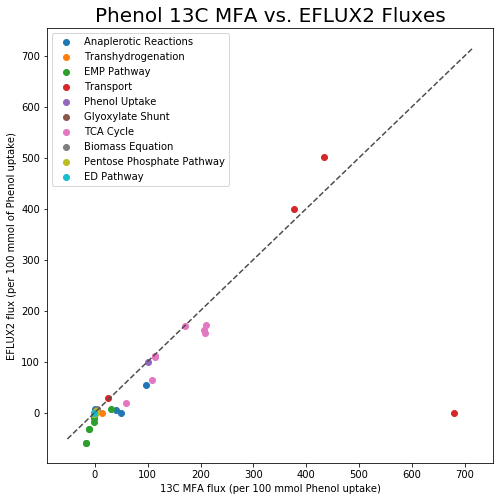

In [40]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='phenol', method='EFLUX2')

##### **Plot observations vs. predictions with confidence intervals**

In [41]:
import matplotlib
import matplotlib.cm as cm
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])
        simulated_std_list = list(pathway_df[str(method) + ' std Value'])
        measured_std_list = list(pathway_df['90% Confidence Upper Bound']-pathway_df['Flux'])
        
        
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        #clb = plt.colorbar(sc)
        #if pathway!='Phenol Uptake':
        ax.errorbar(
                measured_flux_list, simulated_flux_list, xerr=[std1 for std1 in measured_std_list], yerr=[1.9*std for std in simulated_std_list],
                    #fmt="ko",
            #c=.3,
                    ecolor="gray", ls='none',
#                         elinewidth=1,
#                         capsize=2,
                alpha=0.8)
        #ax.set_xlim([min(measured_flux_list), max(measured_flux_list)*1.5])
        #ax.set_xlim([pathway_df.loc[:,'Flux'].min(), pathway_df.loc[:,'Flux'].max()])
        #x_color = clb.to_rgba(measured_flux_list)
#         norm = matplotlib.colors.Normalize(vmin=min(simulated_flux_list), vmax=max(simulated_flux_list), clip=True)
#         mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
#         x_color = np.array([(mapper.to_rgba(v)) for v in simulated_flux_list])
#     for pathway,pathway2,stdpathway, color in zip(measured_flux_list, simulated_flux_list,simulated_std_list, x_color):
#         ax.errorbar(
#                 pathway, pathway2, yerr=1.96*stdpathway,
#                     fmt="ko",
#             c=.3,
#                     #ecolor="",
#                     elinewidth=1,
#                     capsize=2,
#         #capsize=2, linewidth=2.,markersize=6., mew=4., color='darkred',
#                 alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes', fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

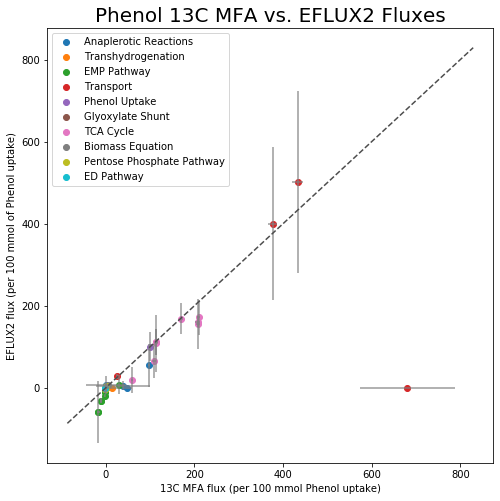

In [42]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='phenol', method='EFLUX2')

## Phenol EFlux Flux Map

Define a function to convert a predicted flux data frame column to a flux map

In [89]:
def map_flux_results(data_df, flux_column):
    fig, ax = plt.subplots(figsize=(15, 20), dpi=50)
    xy = (0.5, 0.5)
    arr_img = plt.imread('./unlabeled_flux_map.png')
    imagebox = OffsetImage(arr_img)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, xy)
    ax.add_artist(ab)

    for _, row in data_df.iterrows():
        if not pd.isnull(row['Location on map']):
            location =  row['Location on map'].replace('(', '').replace(')', '')
            location_list = location.split(',')
            location_tuple = tuple((int(location_list[0]), int(location_list[1])))

            offsetbox = TextArea(f'{row[flux_column]:.1f}')
            ab = AnnotationBbox(offsetbox, xy,
                                xybox=location_tuple,
                                xycoords='data',
                                boxcoords="offset points",
                                frameon=False)
            ax.add_artist(ab)

    # Fix the display limits to see everything
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    plt.show()

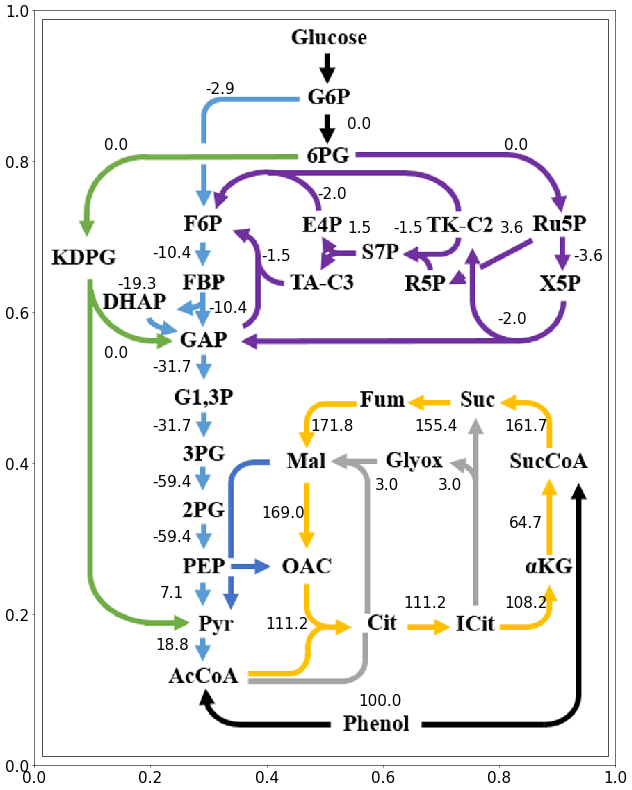

In [90]:
matplotlib.rcParams.update({'font.size': 22})
map_flux_results(obspred_fluxes, 'EFLUX2 Value')

#### **SPOT Predictions**

In [43]:
import cplex
"""
    Creates dictionary of isozymes by parsing GPR:
    Parse GPR into a dict containing isozymes (separated by 'or'). Each isozyme has a set of subunits (separated by 'and') 'and' and 'or' can occur at the same time, or can occur by itself.
    
        Parameters
        ----------
        model : cobrapy model.
        
        
        Returns
        -------
        gpr_dict: dictionary with isozymes.
        
"""
#Code only works for GPRs written in disjunctive normal form (DNF). Majority of models have them in DNF but there are some exceptions. 

def create_gprdict(model):   
    gpr_dict = dict()
    for rxn in model.reactions:
        if rxn.gene_reaction_rule:
            temp = set()
            for x in [x.strip('() ') for x in rxn.gene_reaction_rule.split(' or ')]:
                temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
            gpr_dict[rxn.id] = temp
    return gpr_dict

"""
    Calculates bound value based on transcriptomics data for reactions in gene reaction rule
    
    NOTE: 
    If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
    If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
    If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
    
        Parameters
        ----------
        model : cobrapy model.
        Transcriptomics : pandas dataframe with transcriptomics data.Data frame has gene identifiers as index and just one column with transcript values.  
        rxn : cobrapy model reaction
        
        
        Returns
        -------
        transscript bound value: float.
"""

def findtransboundval_forgprrxns(model, Transcriptomics,rxn):
    finaltransval = 0
    for parallel_gene in create_gprdict(model)[rxn.id]:
        transvals = []
        for gene in parallel_gene:
            if gene in Transcriptomics.index:
                transvals.append(Transcriptomics.loc[gene].values)
            else:
                transvals.append(np.Inf)
            mintransval=np.min(transvals)
        finaltransval = finaltransval + mintransval
    return finaltransval

def SPOTTest(model, Transcriptomics):
    
    mets = [met.id for met in model.metabolites]
    rxns = [rxn.id for rxn in model.reactions]
    nrow = len(mets)
    ncol = len(rxns)

    rev_rxns = ['rev_'+rxn.id for rxn in model.reactions if rxn.reversibility]
    rev_ncol = len(rev_rxns)
    
    """Parse GPR into a dict containing isozymes (separated by 'or')
    # Each isozyme has a set of subunits (separated by 'and')
    #'and' and 'or' can occur at the same time, or can occur by itself."""
    #gpr_dict = create_gprdict(model)

    lb = [0.0 if rxn.reversibility else rxn.lower_bound for rxn in model.reactions] + [0.0 for rxn in model.reactions if rxn.reversibility]
    ub = [rxn.upper_bound for rxn in model.reactions] + [-rxn.lower_bound for rxn in model.reactions if rxn.reversibility]
        
    c = []
    for rxn in model.reactions:
        if rxn.gene_reaction_rule:
        #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
        #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
        #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
        
#             t = np.sum([np.min([Transcriptomics.loc[g] if g in Transcriptomics.index 
#                                 else np.array([np.Inf]) for g in p])
#                         for p in create_gprdict(model)[r.id]])
            transboundval = findtransboundval_forgprrxns(model, Transcriptomics,rxn)
            if transboundval == np.Inf:
                transboundval = 0
            c.append(transboundval)
        else:
            c.append(0.0)
    for rxn in model.reactions:
        if rxn.reversibility:
            if rxn.gene_reaction_rule:
                transboundval = findtransboundval_forgprrxns(model, Transcriptomics,rxn)
                if transboundval == np.Inf:
                    transboundval = 0
                c.append(transboundval)
            else:
                c.append(0.0)

    SPOT = cplex.Cplex()
    SPOT.set_results_stream(None)
    SPOT.parameters.simplex.tolerances.optimality.set(1e-9)
    SPOT.parameters.simplex.tolerances.feasibility.set(1e-9)

    SPOT.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
    SPOT.variables.add(obj=c, lb=lb, ub=ub, names=rxns+rev_rxns)
    for rxn in model.reactions:
        for met, v in rxn.metabolites.items():
            SPOT.linear_constraints.set_coefficients(met.id, rxn.id, v)
    for rxn in model.reactions:
        if rxn.reversibility:
            for met, v in rxn.metabolites.items():
                SPOT.linear_constraints.set_coefficients(met.id, 'rev_'+rxn.id, -v)
    SPOT.quadratic_constraints.add(quad_expr=[rxns+rev_rxns, rxns+rev_rxns, [1]*len(c)],
                                   sense='L', rhs=1.0, name='L2norm')#L indicating <=
    SPOT.objective.set_sense(SPOT.objective.sense.maximize)
    display(SPOT)
    SPOT.solve()
    SPOT_sol = SPOT.solution.get_objective_value()

    sol = type('',(),{})()
    temp = pd.Series(data=SPOT.solution.get_values(), index=rxns+rev_rxns)
    flux = temp.loc[rxns]
    flux_rev = temp.loc[rev_rxns]
    for rxn in model.reactions:
        if rxn.reversibility:
            flux.loc[rxn.id] = flux.loc[rxn.id] - flux_rev.loc['rev_'+rxn.id]
    sol = flux
    sol.objective_value = SPOT.solution.get_objective_value()
    sol.status = SPOT.solution.get_status_string()
    display(model.medium)
    
    return(sol)

In [44]:
#Function for EFLUX2 and SPOT Predictions:
def spotpred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        spotsol = SPOT(model, transcriptdf)
        display(model.medium)
    return spotsol#, spotsol

In [45]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def spotpredthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual spot predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    spotsol_R1 = spotpred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    spotsol_R2 = spotpred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    spotsol_R3 = spotpred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    
    #spot calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    
    spotsol = pd.DataFrame(spotsol_all.mean(axis=1), columns=['fluxes'])
    spotsol_std = spotsol_all.std(axis=1)
    
    return spotsol, spotsol_std

In [46]:
spotsol, spotsol_std = spotpredthreereps(model, df_Trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')#spotsol, spotsol_std = spotspotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

##### **Save solution to data frame**

In [47]:
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['stds'])

In [53]:
# spotsoldf

##### **Check External Metabolites solution**

In [54]:
exchange_list = []
for ind in spotsoldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)
#exchange_list

In [55]:
spotsoldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(spotsoldf.loc[i,:].values)>=0.0001:
        display(spotsoldf.loc[i,:])
    

fluxes   -0.034485
Name: EX_h2o_e, dtype: float64

fluxes    0.141762
Name: EX_h_e, dtype: float64

fluxes    0.001379
Name: EX_leu__L_e, dtype: float64

fluxes    0.004107
Name: EX_acac_e, dtype: float64

fluxes    0.002868
Name: EX_acald_e, dtype: float64

fluxes   -0.003311
Name: EX_nh4_e, dtype: float64

fluxes    0.064963
Name: EX_succ_e, dtype: float64

fluxes    0.110089
Name: EX_co2_e, dtype: float64

fluxes   -0.201773
Name: EX_o2_e, dtype: float64

fluxes    0.002211
Name: EX_fum_e, dtype: float64

fluxes    0.000254
Name: EX_pdima_e, dtype: float64

fluxes    0.001951
Name: EX_val__L_e, dtype: float64

fluxes   -0.073866
Name: EX_phenol_e, dtype: float64

##### **Check FBA solution**

In [56]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    medium["EX_glc__D_e"] = 0.0
    #medium["EX_phenol_e"] = sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.23577895481228953


##### **Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [57]:
#spotsolstddf

In [58]:
obspred_fluxesnew = addpredfluxes_to13cdf(obspred_fluxes, spotsoldf, spotsolstddf, 'phenol', 'SPOT')

In [59]:
obspred_fluxesnew

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,1.847848e+01,100.000000,4.719711e+01
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-2.861408,2.809689e-01,0.007277,1.923396e-06
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-10.425741,-1.023698e+00,0.010415,4.246805e-06
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-10.425741,1.023698e+00,0.010415,4.534032e-06
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-19.303934,1.895470e+00,0.020714,4.756137e-06
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-31.702571,3.112924e+00,0.040501,1.368889e-02
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-31.702571,-3.112924e+00,0.040501,-1.368889e-02
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-59.412283,6.792789e-12,2.455643,-1.072497e-03
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-59.412283,3.951076e+01,4.212490,7.209187e+00
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,7.056541,1.222229e+01,-55.122910,-2.517052e+01


### Plot SPOT vs 13C MFA

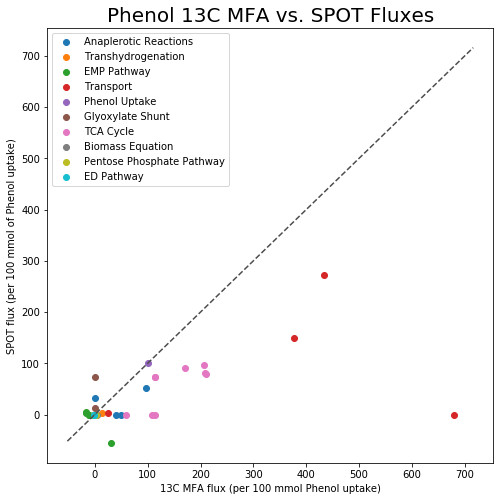

In [60]:
scatterplotcomp_obs_vs_pred(obspred_fluxesnew, substrate='phenol', method='SPOT')

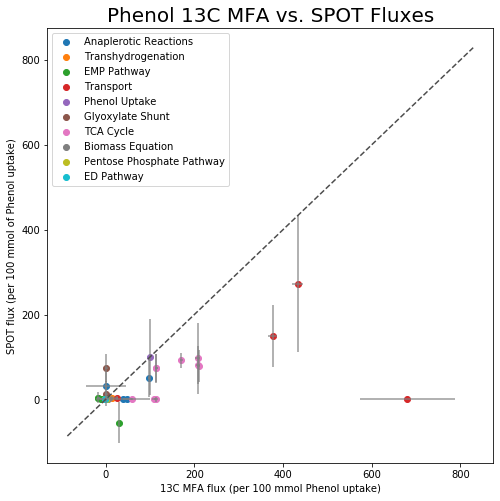

In [61]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxesnew, substrate='phenol', method='SPOT')

### Map phenol SPOT fluxes

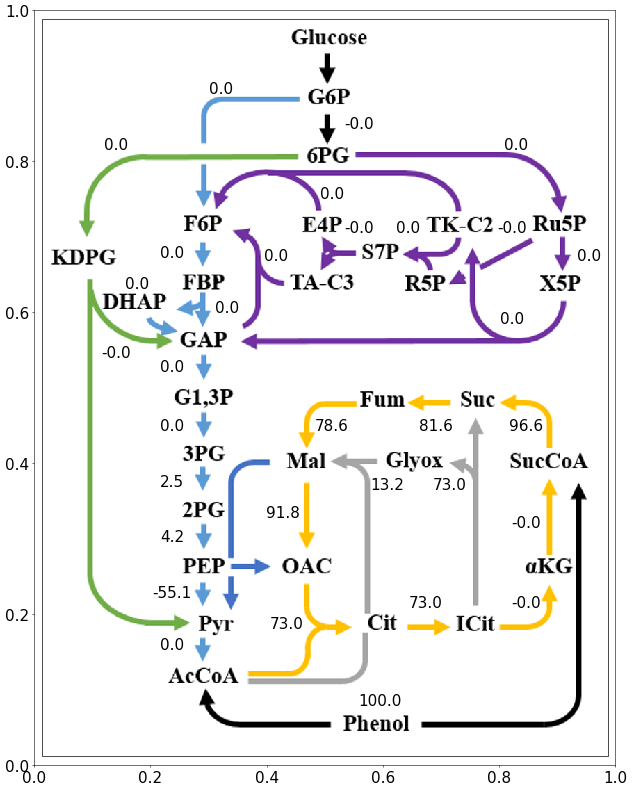

In [91]:
matplotlib.rcParams.update({'font.size': 22})
map_flux_results(obspred_fluxes, 'SPOT Value')

### Run phenol flux FBA

In [92]:
with model:
    model.objective = 'Growth_Phenol'
    mediumphe = model.medium
    
    # This is to prevent medium components other than phenol from being growth limitations
    mediumphe = {key:1000 for (key,value) in model.medium.items()}
    
    mediumphe["EX_glc__D_e"] = 0.0
    mediumphe["EX_phenol_e"] = 100.0
    
    model.medium = mediumphe
#     print(model.medium)
    solutionphe = model.optimize()
    
print(solutionphe)

<Solution 9.550 at 0x7f2ebe551750>


In [93]:
for r in model.metabolites.get_by_id('phenol_e').reactions:
    print(solutionphe.fluxes[r.id], r)
for r in model.metabolites.get_by_id('phenol_c').reactions:
    print(solutionphe.fluxes[r.id], r)

100.0 phenol_transport: phenol_e <=> phenol_c
-100.0 EX_phenol_e: phenol_e <=> 
100.0 PHEMOX: h_c + nadh_c + o2_c + phenol_c --> catechol_c + h2o_c + nad_c
100.0 phenol_transport: phenol_e <=> phenol_c


### Add Phenol FBA flux values to test_df 

In [94]:
# fbasoldf = pd.DataFrame(solutionphe, columns=['fluxes'])

In [95]:
# obspred_fluxesnew = addpredfluxes_to13cdf(obspred_fluxes, solutionphe, None, 'phenol', 'FBA')

In [96]:
FBA_fluxes_phe = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_phe = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_phe += min([get_flux_value(v, solutionphe) for v in and_split])
    FBA_fluxes_phe.append(flux_value_phe)
    
phenol_fluxes['FBA Value'] = FBA_fluxes_phe
phenol_fluxes

,Pathway,Forward Reactions,Reaction,Location on map,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value,FBA Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,"( 80, -450)",1.000000e+02,1.000000e+02,100.0000,100.000000,1.847848e+01,100.000000,4.719711e+01,100.000000
1,EMP Pathway,PGI,G6P <-> F6P,"(-150, 430)",-4.793000e-01,-1.421900e+00,0.9306,-2.861408,2.809689e-01,0.007277,1.923396e-06,-4.243637
2,EMP Pathway,PFK or reverse_FBP,F6P + ATP -> FBP,"(-220, 195)",-2.000000e+00,-2.000000e+00,-0.7683,-10.425741,-1.023698e+00,0.010415,4.246805e-06,-15.462221
3,EMP Pathway,FBA,FBP <-> DHAP + GAP,"(-140, 115)",-2.000000e+00,-2.000000e+00,-0.7683,-10.425741,1.023698e+00,0.010415,4.534032e-06,-15.462221
4,EMP Pathway,TPI,DHAP <-> GAP,"(-270, 150)",-2.000000e+00,-2.000000e+00,-0.7683,-19.303934,1.895470e+00,0.020714,4.756137e-06,-28.629104
5,EMP Pathway,GAPD,"GAP <-> G1,3P","(-220, 30)",-1.079070e+01,-1.122350e+01,-9.1040,-31.702571,3.112924e+00,0.040501,1.368889e-02,-47.017012
6,EMP Pathway,reverse_PGK,"G1,3P <-> 3PG + ATP + NADH","(-220, -55)",-1.079070e+01,-1.122350e+01,-9.1040,-31.702571,-3.112924e+00,0.040501,-1.368889e-02,-47.017012
7,EMP Pathway,PGM_1 or reverse_PGM,3PG <-> 2PG,"(-220, -135)",-1.625380e+01,-1.695560e+01,-13.6034,-59.412283,6.792789e-12,2.455643,-1.072497e-03,-54.959072
8,EMP Pathway,ENO,2PG <-> PEP,"(-220, -215)",-1.625380e+01,-1.695560e+01,-13.6034,-59.412283,3.951076e+01,4.212490,7.209187e+00,-54.959072
9,EMP Pathway,PPS or reverse_FRUpts2pp or reverse_SBTpts or ...,PEP <-> Pyr + ATP,"(-220, -295)",2.999990e+01,0.000000e+00,30.0000,7.056541,1.222229e+01,-55.122910,-2.517052e+01,58.148164


### Plot FBA vs 13C MFA

!!!To Do: Change functions to integrate no std situation!!!

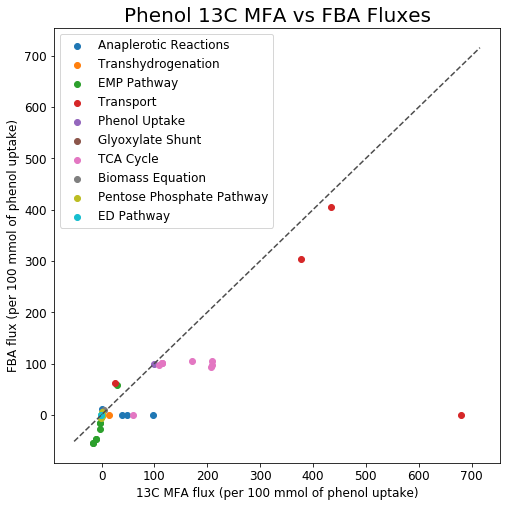

In [99]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['FBA Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'FBA flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

### Map FBA Fluxes

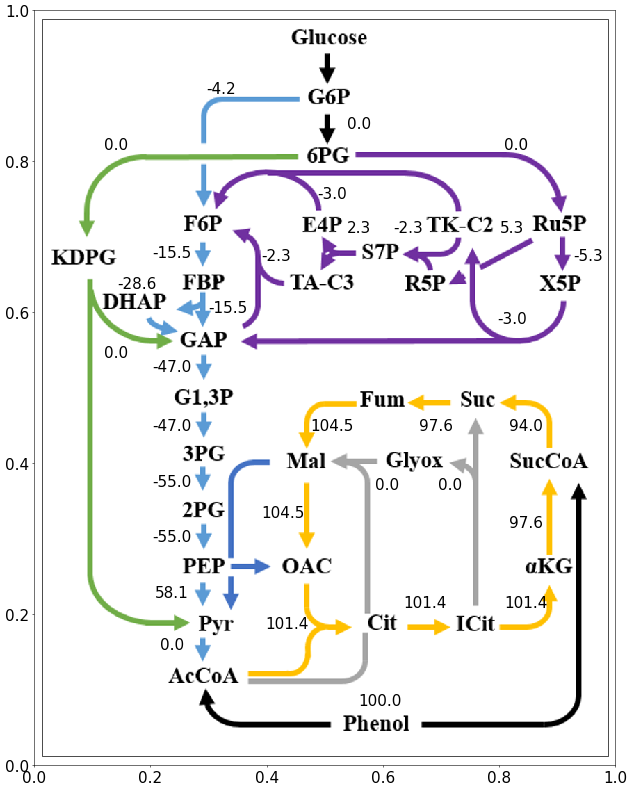

In [100]:
matplotlib.rcParams.update({'font.size': 22})
map_flux_results(obspred_fluxes, 'FBA Value')

### Map 13C MFA Fluxes

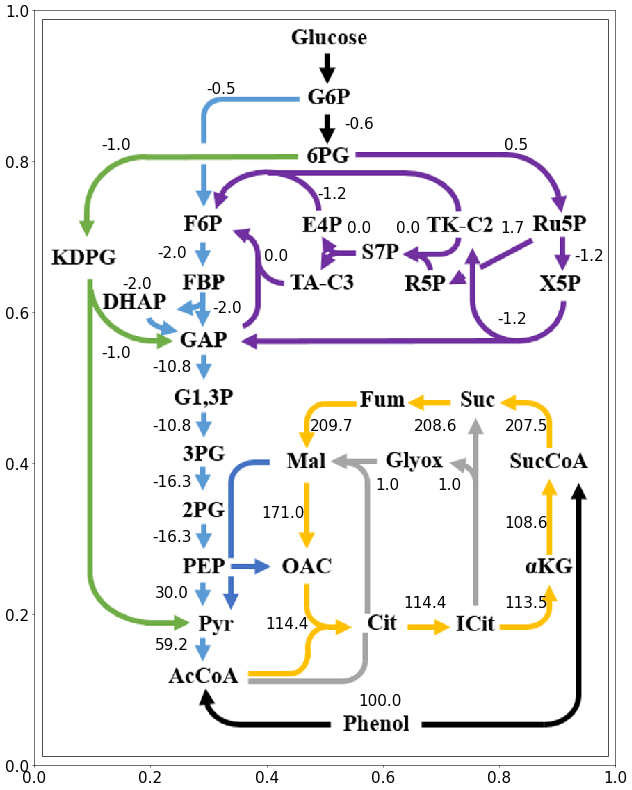

In [101]:
matplotlib.rcParams.update({'font.size': 22})
map_flux_results(obspred_fluxes, 'Flux')

In [105]:
for r in model.metabolites.get_by_id('nadh_c').reactions:
    if model.metabolites.get_by_id('atp_c') in r.metabolites:
        print(r)

FAO1: atp_c + 7.0 coa_c + 6.0 fad_c + 6.0 h2o_c + 6.0 nad_c + ttdca_c --> 7.0 accoa_c + amp_c + 6.0 fadh2_c + 6.0 h_c + 6.0 nadh_c + ppi_c
FAO3: atp_c + 9.0 coa_c + 8.0 fad_c + 8.0 h2o_c + 8.0 nad_c + ocdca_c --> 9.0 accoa_c + amp_c + 8.0 fadh2_c + 8.0 h_c + 8.0 nadh_c + ppi_c
FAO10: atp_c + 9.0 coa_c + 7.0 fad_c + 8.0 h2o_c + 8.0 nad_c + ocdcea_c --> 9.0 accoa_c + amp_c + 7.0 fadh2_c + 8.0 h_c + 8.0 nadh_c + ppi_c
FAO2: atp_c + 8.0 coa_c + 7.0 fad_c + 7.0 h2o_c + hdca_c + 7.0 nad_c --> 8.0 accoa_c + amp_c + 7.0 fadh2_c + 7.0 h_c + 7.0 nadh_c + ppi_c
FAO11: atp_c + 8.0 coa_c + 6.0 fad_c + 7.0 h2o_c + hdcea_c + 7.0 nad_c --> 8.0 accoa_c + amp_c + 6.0 fadh2_c + 7.0 h_c + 7.0 nadh_c + ppi_c


In [111]:
for r in model.metabolites.get_by_id('atp_c').reactions:
    if model.metabolites.get_by_id('atp_c') in r.products: 
        print(r.name, r)

ATP synthase (four protons for one ATP) (periplasm) ATPS4rpp: adp_c + 4.0 h_p + pi_c --> atp_c + h2o_c + 3.0 h_c
Pyruvate kinase PYK: adp_c + h_c + pep_c --> atp_c + pyr_c


In [110]:
for r in model.metabolites.get_by_id('nadh_c').reactions:
    if model.metabolites.get_by_id('nadh_c') in r.reactants: 
        print(r)

3HCINNMH: 3hcinnm_c + h_c + nadh_c + o2_c --> dhcinnm_c + h2o_c + nad_c
3HPAOX: 3hoxpac_c + nadh_c + o2_c --> 34dhpha_c + h2o_c + nad_c
MOADSUx: iscssh_c + moadamp_c + nadh_c --> amp_c + iscs_c + moadcosh_c + nad_c
RDXR: nadh_c + 2.0 rdxo_c --> h_c + nad_c + 2.0 rdxr_c
P5CRx: 1pyr5c_c + 2.0 h_c + nadh_c --> nad_c + pro__L_c
HACD4: 3odcoa_c + h_c + nadh_c <=> 3hdcoa_c + nad_c
HACD1_2: aacoa_c + h_c + nadh_c <=> 3hbycoa_c + nad_c
MECDPDH2: 2mecdp_c + nadh_c --> h2mb4p_c + h2o_c + nad_c
XMO: h_c + nadh_c + o2_c + tol_c --> bzalc_c + h2o_c + nad_c
ALCD19: glyald_c + h_c + nadh_c <=> glyc_c + nad_c
PTOLDOX: h_c + nadh_c + o2_c + p_tol_c --> dh4mchc_c + nad_c
EAR141x: h_c + nadh_c + t3c7mrseACP_c --> nad_c + tdeACP_c
POAACR: nadh_c + poaac_c --> 3amac_c + h2o_c + nad_c
EAR140x: h_c + nadh_c + tmrs2eACP_c --> myrsACP_c + nad_c
MXMO: h_c + m_xyl_c + nadh_c + o2_c --> 3mbzalc_c + h2o_c + nad_c
ACOAD1: b2coa_c + h_c + nadh_c --> btcoa_c + nad_c
BZ12DOX: bz_c + h_c + nadh_c + o2_c --> bz12diol_c 

In [115]:
for r in model.reactions:
    if 'ATP' in r.name:
        print(r.name, r)

Arsenite efflux via ATP hydrolysis (periplasm) ASO3t8pp: aso3_c + atp_c + h2o_c --> adp_c + aso3_p + h_c + pi_c
ATP amine hydrolysis (spontaneous) ATPHs: atp_c + h2o_c + h_c --> itp_c + nh4_c
ATP phosphoribosyltransferase ATPPRT: atp_c + prpp_c --> ppi_c + prbatp_c
ATP synthase (four protons for one ATP) (periplasm) ATPS4rpp: adp_c + 4.0 h_p + pi_c --> atp_c + h2o_c + 3.0 h_c
CAATPS CAATPS: atp_c + 2.0 ca2_c + h2o_c --> adp_c + 2.0 ca2_e + h_e + pi_c
Copper export via ATPase Cut1: atp_c + cu2_c + h2o_c --> adp_c + cu2_e + h_c + pi_c
DATP amine hydrolysis (spontaneous) DATPHs: datp_c + h2o_c + h_c --> ditp_c + nh4_c
Deoxyguanylate kinase (dGMP:ATP) DGK1: atp_c + dgmp_c <=> adp_c + dgdp_c
Deoxyuridine kinase (ATP:Deoxyuridine) DURIK1: atp_c + duri_c --> adp_c + dump_c + h_c
Guanylate kinase (GMP:ATP) GK1: atp_c + gmp_c <=> adp_c + gdp_c
Glucan transport via ATP transporter GLUCAN2abc: atp_c + glucan6_e + h2o_c --> adp_c + glucan6_c + h_c + pi_c
Glucan transport via ATP transporter GLUCAN

In [120]:
for r in model.metabolites.get_by_id('q8h2_c').reactions:
    print(r)

MDH2: mal__L_c + q8_c --> oaa_c + q8h2_c
GLYCTO2: glyclt_c + q8_c --> glx_c + q8h2_c
CYTBDpp: 2.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 2.0 h_p + q8_c
HYD1pp: h2_c + 2.0 h_c + q8_c --> 2.0 h_p + q8h2_c
NADPHQR2: h_c + nadph_c + q8_c --> nadp_c + q8h2_c
NADH6: 4.5 h_c + nadh_c + q8_c --> 3.5 h_e + nad_c + q8h2_c
DHORD2: dhor__S_c + q8_c --> orot_c + q8h2_c
CYTBD: 2.0 h_c + 0.5 o2_c + q8h2_c --> h2o_c + 2.0 h_e + q8_c
HYD1: h2_c + 2.0 h_c + q8_c --> 2.0 h_e + q8h2_c
NADH5: h_c + nadh_c + q8_c --> nad_c + q8h2_c
POX: h2o_c + pyr_c + q8_c --> ac_c + co2_c + q8h2_c
GLCDpp: glc__D_p + h2o_p + q8_c --> glcn_p + h_p + q8h2_c
SUCDi: q8_c + succ_c --> fum_c + q8h2_c
L_LACD2: lac__L_c + q8_c --> pyr_c + q8h2_c
